# ASU HERA Memo: Mapping HERA's Primary Beam
### Tyler Cox

One of the challenges of observing highly redshifted 21 cm emission is separating the signal from bright foreground sources. Simulations have found that when these bright foreground sources are far from HERA's center, their flux is significantly reduced due to beam attenuation and they become difficult to separate from the 21 cm signal. Knowledge of the shape of the beam at different frequencies will allow for precise calibration of the array, which will help to isolate the 21 cm cosmological signal from bright foregrounds. The goal of this notebook is to observe HERA
s beam response at different frequency ranges by using IDR2.1 data to observe foreground point sources as they drift across the beam.

## 1. Imaging IDR2.1 Data

To map HERA's primary beam by tracking sources as they move across the beam, we need to image a set of HERA data that is sensitive enough to that we can accurately measure of flux of sources as they move across the beam. The data set that we have decided to image to make this measurement is the [IDR2.1 data release](http://reionization.org/wp-content/uploads/2013/03/HERA_Memo45_IDR2.1.html). H1C IDR 2.1 contains pre-calibrated, LST-binned data from observations made from 18 nearly-consecutive nights of data. Since this data has been binned over many days of observation, it should provide the sensitivity needed to accurately measure the flux of the sources we will choose to track across the beam.

One change that needed to be made to this data before making beam measurements from the images was splitting each data file from one 20 minute time integration into 10 two-minute time integrations. The reason for doing this was to create more images with less time passage between subsequent images, thus creating a smoother beam measurement for each source. Splitting the images into two-minute time integrations does reduce the sensitivity of the measurements but they should still allow us to make accurate beam measurements. We use pyuvdata to split these files in two-minute time integrations.

Once we've created a set of two-minute time integration data, we image by using CASA to flag all of the autocorrelations and run the CLEAN command below on all two time integrations:

```
clean(niter = 6000, weighting = 'briggs', robust = '-0.5', 
      imsize = [512,512], cell = ['250arcsec'], mode = 'mfs', nterms = 1)
```
We also image the data in bandwidths of 10 MHz (110-120 MHz, 120-130 MHz, ...) and 20 MHz (110-130 MHz, 130-150 MHz, ...), so that we can measure the beam response at different frequencies. This is done by changing the spectral window in the CLEAN command:

```

# Example CLEAN command for imaging data using 180-190 MHz frequencies

clean(niter = 6000, weighting = 'briggs', robust = '-0.5', imsize = [512,512], 
      cell = ['250arcsec'], mode = 'mfs', nterms = 1, spw = '0:819~912')
      
      
```

Now that we've imaged all of the time split IDR2.1 data at different frequency ranges, we use these images to make beam measurements of sources as they track across the beam.

## 2. Tracking Foreground Sources

With the images generated for each set of frequencies, we can start tracking bright foreground sources as they drift across the beam. To find these sources, the [HERA_calibration_sources](https://github.com/dannyjacobs/asu_hera/tree/master/HERA_calibration_sources) code is used. This package uses the TGSS ADR catalogue to find radio sources within a right ascension and declination range and some minimum flux. Once the desired values are entered, the name of the source, its right ascension, declination, and total flux are returned in a pandas dataframe.

Using this package, we can isolate bright sources within a narrow declination range over the entire right ascension range that was observed in IDR 2.1. We keep the declination range narrow so that the final observed beam map can be compared to a cut from the beam model centered at HERA's zenith declination.

In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS
from HERA_calibration_sources import add_fluxes
from pyuvdata import UVBeam
import healpy as hp

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

In [2]:
tb = add_fluxes(RA_range=('00:00:00','13:00:00'),dec_range=1, min_flux=6)
tb

,Name of Center,RA,Dec,Total flux in region
0,TGSSADR J020012.1-305327,30.050440,-30.891060,25311.699249
1,TGSSADR J043300.3-295615,68.251488,-29.937559,10452.800014
2,TGSSADR J043736.5-295406,69.402321,-29.901720,9057.500076
3,TGSSADR J045826.4-300720,74.610413,-30.122379,19984.100246
4,TGSSADR J045514.2-300650,73.809464,-30.113991,23645.400387
5,TGSSADR J051330.6-303042,78.377602,-30.511909,18364.499821
6,TGSSADR J073819.7-302505,114.582474,-30.418230,14347.499702
7,TGSSADR J082126.4-301105,125.360031,-30.184980,20358.700781


The function below is where we track the flux sources found in the HERA_calibration_sources code as they move across the beam. For each image, the function loops through the list of sources to find the flux of the source if it exists in the image. We find whether or not the source is in the image by converting the source's right ascension and declination into a pixel value using astropy. The flux found at this pixel value is then divided by its true total flux, taken from the TGSS ADR catalog, to obtain a beam measurement at a particular angle from HERA's zenith. These values are then plotted as a function of angle from the telescope's zenith and compared to the beam model.

In [3]:
def track_sources(fits_files, sources, pos_buffer = 1):
    '''
    Creates a beam measurement for each source by measuring their flux in fits images generated from HERA data 
    and dividing by their true total flux.
    
    Parameters
    ----------
    fits_files : array-like
        Fits files generated from the imaging pipeline to take flux measurements from
    
    sources : dict
        Dictionary of sources containing information about their positions and total flux
        generated by HERA_calibration_sources. Used to track sources to make beam measurements
        
    pos_buffer : int, optional
        
    
    Returns
    -------
    plot_data : dict
        Dictionary containing the zenith angle and corresponding beam measurement for each source. 
        The key is the source name.
    
    '''
    
    plot_data = {v['Name of Center']: {'RA_diff': [], 'Flux': []} for _,v in tb.iterrows()}
    
    for f in fits_files:
        with fits.open(f) as HDU:
            
            
            # Read in file information

            fits_info = HDU[0].header
            ax1        = fits_info['NAXIS1']
            ax2        = fits_info['NAXIS2']
            c_ra       = fits_info['OBSRA']
            c_dec      = fits_info['OBSDEC']
            pix_size   = abs(fits_info['CDELT1'])

            
            # Flip to data to correct the axes
            data = HDU[0].data
            data = np.flip(data[0][0],axis=0)

            w = WCS(f)

            for _,src in sources.iterrows():

                # Convert a position to pixel values
                idx_1,idx_2 = w.all_world2pix(src['RA'],src['Dec'],0,0,0)[:2]

                if not np.isnan(idx_1) and not np.isnan(idx_2):
                    idx_1 = int(idx_1)
                    idx_2 = int(ax2-idx_2)


                # ax1 is the right-most pixel, ax2 is the bottom-most pixel
                # we want to make sure that the both values are within the
                # correct range

                if (pos_buffer < idx_1 < ax1-pos_buffer) and (pos_buffer < idx_2 < ax2-pos_buffer):

                    max_flux = np.abs(data[idx_2-pos_buffer:idx_2+pos_buffer,idx_1-pos_buffer:idx_1+pos_buffer]).max()
                    plot_data[src['Name of Center']]['Flux'].append(max_flux/src['Total flux in region'])
                    
                    ra_diff = c_ra-src['RA']

                    # Correct for the difference in c_ra error
                    if ra_diff > pix_size*ax1:
                        ra_diff -= 360
                    if ra_diff < -pix_size*ax1:
                        ra_diff += 360

                    plot_data[src['Name of Center']]['RA_diff'].append(ra_diff)
                    
    return plot_data

With the function below, we combine the beam measurements made from the functions above into a single beam measurement. This is done by gridding the measurements by zenith angle and averaging overlapping measurements made at each angle.

In [4]:
def observed_beam(cleaned_set):
    '''
    
    Creates a single beam cut from beam measurements made for each source
    
    Parameters
    ----------
    cleaned_set : dict
        Dictionary of normal flux values and their corresponding angle from zenith for each source.
        Obtained from the track_sources function.
    
    Returns
    -------
    theta : array-like
        Zenith angles for the final beam measurement
    obs_beam : array-like
        Single beam measurement compiled from individual measurements
    beam_std : array-like
        Standard deviation of the beam for each zenith angle measure 
    '''
    n = 0
    x = []
    y = []

    min_x = 30
    max_x = -30

    for _,src in plot_data.iteritems():
        x.append(src['RA_diff'])
        flux = np.array(src['Flux'])
        y.append(flux)
        if len(src['Flux']) > 0:
            if len(src['Flux']) > n:
                n = len(src['Flux'])
            if min(src['RA_diff']) < min_x:
                min_x = min(src['RA_diff'])
            if max(src['RA_diff']) > max_x:
                max_x = max(src['RA_diff'])

    bins = np.linspace(min_x, max_x, n)
    vals = np.zeros(n)
    counts = np.ones(n)
    std_arr = [[] for _ in range(n)]

    for i, d in enumerate(x):
        idx = np.digitize(d, bins) - 1
        vals[idx] += y[i]
        counts[idx] += 1
        for m,n in enumerate(idx):
            std_arr[n].append(y[i][m])

    obs_beam = vals/counts
    #obs_beam /= obs_beam.max()
    #obs_beam = 10*np.log10(obs_beam)
    #beam_std = np.array([np.std(10*np.log10(std)) for std in std_arr])
    #return bins, obs_beam, beam_std
    return bins, obs_beam

Using the two functions above with the source finding code, we can create a single beam measurement. We use images generated using the frequencies 110-130 MHz to make our first beam measurement. If this is done correctly, we hope to see a beam measurement that appears to be roughly gaussian looking at the zenith angles we will be measuring out to.

In [11]:
freq_range = '180-190MHz_uniform'
freq_ends = [180,190]

files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/'+freq_range+'/imgs/*fits'))
plot_data = track_sources(files,tb)

#theta, obs_beam, obs_std = observed_beam(plot_data)
theta, obs_beam = observed_beam(plot_data)

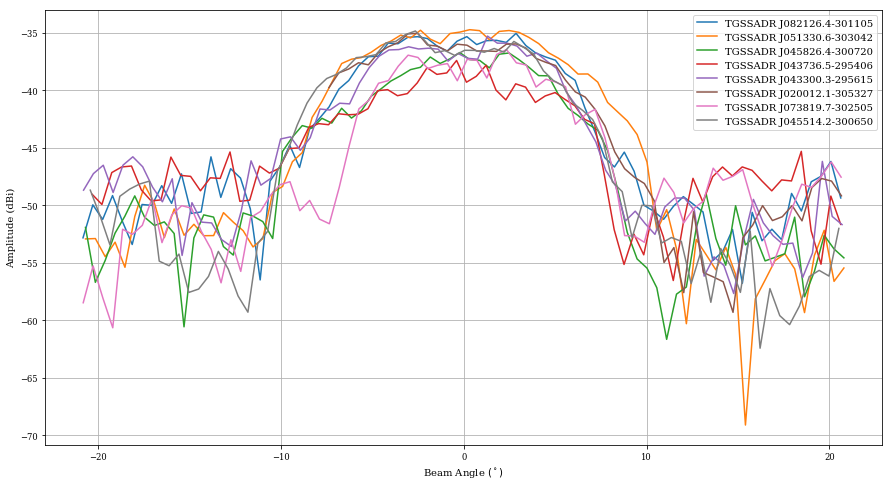

In [12]:
plt.figure(figsize=(15,8))

for key,item in plot_data.items():
    flux = np.array(item['Flux'])
    plt.plot(item['RA_diff'],10*np.log10(flux),label=key)

plt.xlabel(r'Beam Angle $(^\circ)$')
plt.ylabel(r'Amplitude (dBi)')
plt.legend()
plt.grid()
plt.show()

The beam measurement above looks roughly like what we were expecting. The real test will comparing the beam measurement to a simulation of HERA's beam at these frequencies. We can now look into modeling HERA's beam at the range of frequencies used in this measurement, 110-130 MHz.

## 3. Modeling HERA's Beam

To model HERA's beam, which we will use to compare to our beam measurement, we will use a electromagnetic simulation of HERA's antenna created by Nicolas Fagnoni. This simulation contains the beam response at every integer frequency that HERA is currently capable of observing. We'll start by importing this simulation using the UVBeam object in [pyuvdata](https://github.com/RadioAstronomySoftwareGroup/pyuvdata).

In [13]:
hera_beam = UVBeam() #Instantiating HERA's beam as a UVBeam object
hera_beam.read_beamfits("NF_HERA_power_beam_healpix.fits") #Reading in the beam model

Now, we define a function to find HERA's beam at a specific frequency. We can use this function to find the shape of the beam over a range of frequencies by averaging beam models over a particular frequency range.

In [8]:
def hera_beam_freq_slice(hera_beam, freq, beam_center = 90, ang_from_center = 15, n = 100):
    '''
    Returns a beam cut at a defined frequency
    
    Parameters
    ----------
    hera_beam : UVBeam
        HERA beam model simulation read into a UVBeam object
    freq: int
        Frequency to pull from simulation
    beam_center: float, optional
        Zenith declination, set to 90 degrees in the simulation
    ang_from_center: int
        Angle from zenith to map the simulated beam out to
    n: int
        Number of points in the plot 
    
    Returns
    -------
    ang : array-like
        Angle from zenith for each point in the beam model
    beam_slice: array-like
        Beam model at the given frequency and angle range
    
    '''
    ang = np.linspace(beam_center-ang_from_center,beam_center+ang_from_center,n)
    beam_slice     = []
    beam_map       = hera_beam.data_array[0][0][0][freq-100]
    beam_map_norm  = beam_map/np.max(beam_map) 
    
    for i in ang:
        beam_slice.append(hp.get_interp_val(beam_map_norm,0, i, lonlat=True))  
    
    return ang, np.array(beam_slice)

To make sure that this function works, we can plot a few beam models to see they look similar to the plots made in [beam simulation memo](https://github.com/Nicolas-Fagnoni/Simulations/blob/master/Memo/Memo%20-%20CST%20simulation%20of%20HERA%20and%20comparison%20with%20measurements.pdf).

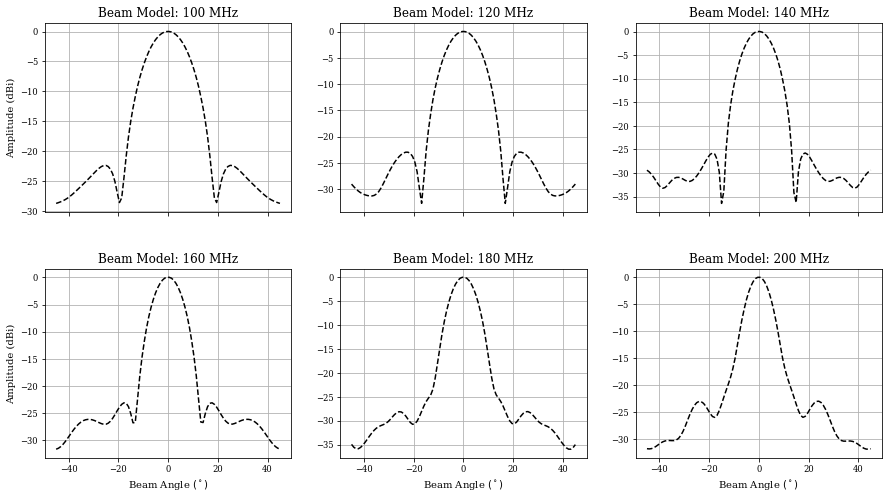

In [9]:
freqs = np.array([100,120,140,160,180,200])
model_beam = np.zeros(100)

fig, axs = plt.subplots(2,3, figsize=(15, 8), facecolor='w', edgecolor='k',sharex='col')
fig.subplots_adjust(hspace = .3)

axs = axs.ravel()

for i,freq in enumerate(freqs):
    ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=45, n=100)
    model_beam = 10*np.log10(beam)
    axs[i].plot(ang-90,model_beam,'k--')
    axs[i].set_title('Beam Model: ' + str(freq) + ' MHz')
    axs[i].grid()
    if i > 2:
        axs[i].set_xlabel('Beam Angle $(^\circ)$')
    if i == 0 or i == 3:
        axs[i].set_ylabel('Amplitude (dBi)')


plt.show()

We can also plot a model averaged over a frequency range against models at a single frequency to make sure the averaged model is consistent with the single frequency models.

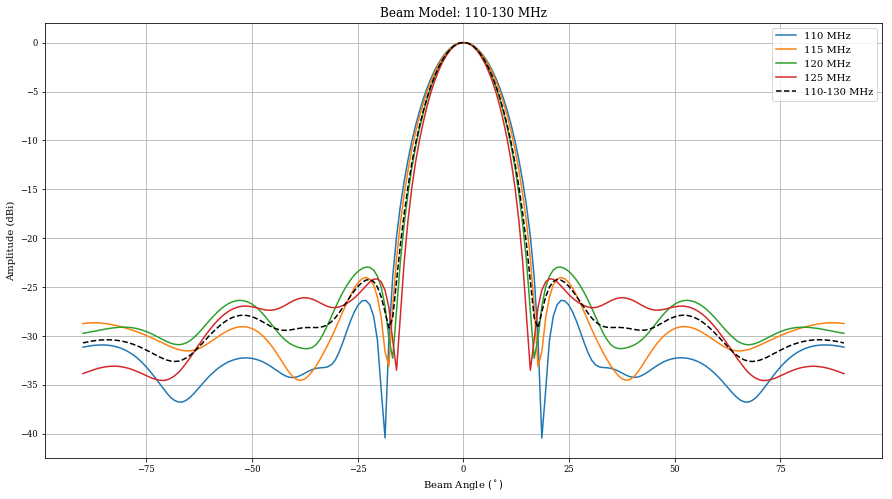

In [10]:
freqs = np.arange(110,130)
model_beam = np.zeros(200)

plt.figure(figsize=(15,8))

for freq in freqs:
    ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=90, n=200)
    model_beam += beam
    if freq%5 == 0:
        plt.plot(ang-90,10*np.log10(beam),label=(str(freq) + ' MHz'))
        
model_beam /= freqs.shape[0]
model_beam = 10*np.log10(model_beam)

plt.xlabel(r'Beam Angle $(^\circ)$')
plt.ylabel(r'Amplitude (dBi)')
plt.title(r'Beam Model: 110-130 MHz')
plt.plot(ang-90,model_beam,'k--', label = '110-130 MHz')
plt.grid()
plt.legend()
plt.show()

## 4. Comparing the Beam Measurement and the Model

With the measurement and simulation both made, we can now plot the simulation against the model for the frequency range 110-130 MHz. We will also plot all of the 20 MHz and 10 MHz bandwith beam measurements to see how they compare to the models.

In [12]:
freqs = np.arange(freq_ends[0],freq_ends[1])
model_beam = []

for freq in freqs:
    ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=15, n=100)
    model_beam.append(beam)

model_beam = np.mean(model_beam, axis = 0)
model_beam /= model_beam.max()
model_beam = 10*np.log10(model_beam)

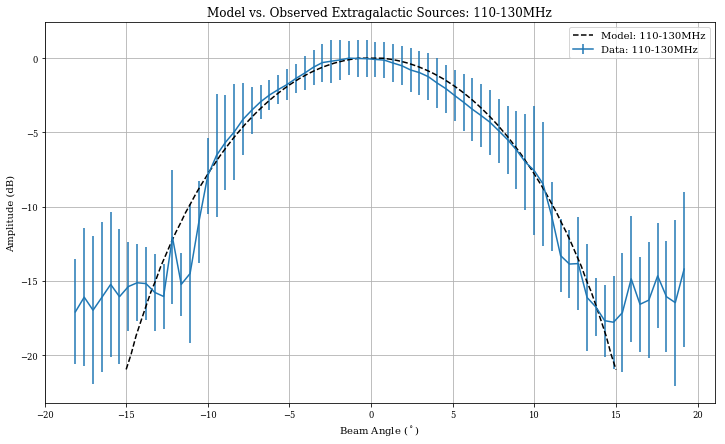

In [13]:
plt.figure(figsize=(12,7))

plt.plot(ang-90,model_beam,'k--',label=(r'Model: ' + freq_range))
plt.errorbar(theta[5:-3],obs_beam[4:-4],yerr=obs_std[4:-4],label='Data: ' + freq_range)
plt.legend()
plt.title('Model vs. Observed Extragalactic Sources: ' + freq_range)
plt.xlabel(r'Beam Angle ($^\circ$)')
plt.ylabel('Amplitude (dB)')
plt.grid()
plt.show()

As we can see above, the beam map created from measuring the flux of the sources matches the model well out to a zenith angle of ~$12^\circ$. It is possible that the noise level is being hit and that is what's causing the beam measurement to flatten out past ~$12^\circ$ from zenith, but this is something that will require more work.

Now that we've successfully produced a beam measurement, we can use the same procedure as above for the rest of the 20 MHz bandwidth images.

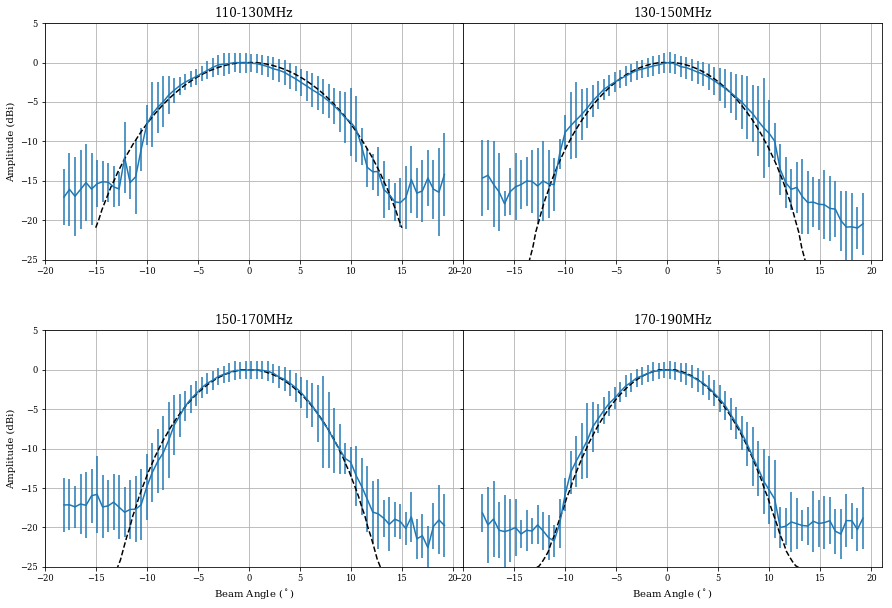

In [14]:
freq_range = ['110-130MHz','130-150MHz','150-170MHz','170-190MHz']
freq_ends = [[110,130],[130,150],[150,170],[170,190]]

fig, axs = plt.subplots(2,2, figsize=(15, 10), facecolor='w', edgecolor='k', sharey=True)
fig.subplots_adjust(hspace = .3,wspace=0.0)

axs = axs.ravel()

for i,freq_set in enumerate(freq_range):
    
    
    # Find the files and track the sources
    
    files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/' + freq_set + '/imgs/*fits'))
    plot_data = track_sources(files,tb)
        
    # Model the beam for a range of frequencies
    
    freqs = np.arange(freq_ends[i][0],freq_ends[i][1])
    model_beam = []
    
    for freq in freqs:
        ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=15, n=100)
        model_beam.append(beam)
        
    model_beam = np.mean(model_beam, axis = 0)
    model_beam /= model_beam.max()
    model_beam = 10*np.log10(model_beam)
    
    
    # Find the measured beam and standard deviation for error bars
    
    theta, obs_beam, obs_std = observed_beam(plot_data)
    
    np.save(freq_set + '_model',np.vstack((ang,model_beam)))
    np.save(freq_set,np.vstack((theta,obs_beam,obs_std)))
    # Plot the beam and model
    
    axs[i].plot(ang-90,model_beam,'k--',label=(r'Model: ' + freq_set))
    axs[i].errorbar(theta[5:-3],obs_beam[4:-4],yerr=obs_std[4:-4],label='Data: ' + freq_set)
    axs[i].set_title(freq_set)
    axs[i].grid()
    axs[i].set_ylim([-25,5])
    
    if i % 2 == 0:
        axs[i].set_ylabel(r'Amplitude (dBi)')
        
    if i > 1:
        axs[i].set_xlabel(r'Beam Angle ($^\circ$)')
    
plt.show()

The beam measurements in the plots above also seem to match well out to ~$12^\circ$. We can also recreate the plots above for 10 MHz bandwidth images beginning at 110 MHz and ending at 190 MHz.

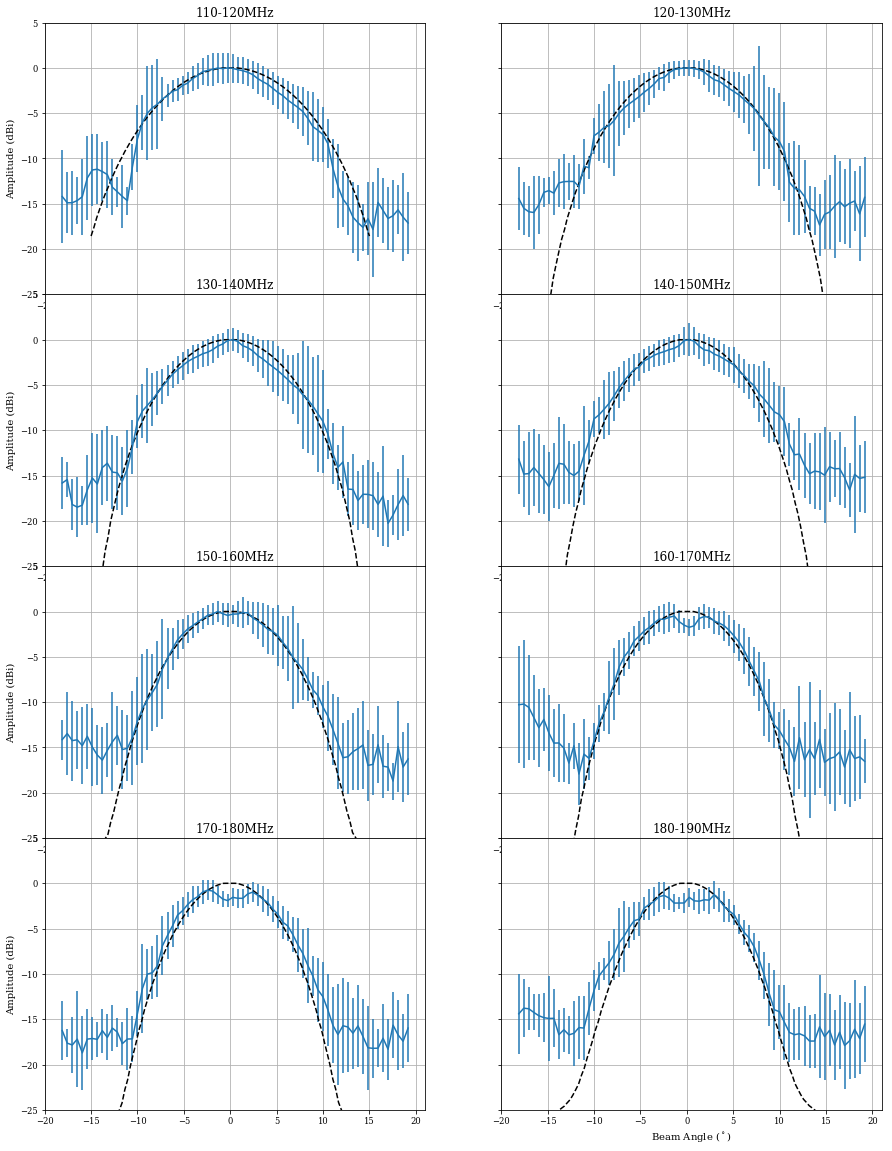

In [15]:
freq_range = ['110-120MHz','120-130MHz',
              '130-140MHz','140-150MHz',
              '150-160MHz','160-170MHz',
              '170-180MHz','180-190MHz']

freq_ends = [[110,120], [120,130],
             [130,140], [140,150],
             [150,160], [160,170],
             [170,180], [180,190]]

fig, axs = plt.subplots(4,2, figsize=(15, 20), facecolor='w', edgecolor='k', sharey=True)
fig.subplots_adjust(hspace = 0.0)

axs = axs.ravel()

for i,freq_set in enumerate(freq_range):
    
    # Find the files and track the sources
    
    files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/' + freq_set + '/imgs/*fits'))
    plot_data = track_sources(files,tb)
    cleaned_set = {k: v for k,v in plot_data.iteritems() if len(v['Flux']) == 77}

    
    # Model the beam for a range of frequencies
    
    freqs = np.arange(freq_ends[i][0],freq_ends[i][1])
    model_beam = []
    
    for freq in freqs:
        ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=15, n=100)
        model_beam.append(beam)
        
    model_beam = np.mean(model_beam, axis = 0)
    model_beam /= model_beam.max()
    model_beam = 10*np.log10(model_beam)
    
    
    # Find the observed beam and standard deviation for error bars
    
    theta, obs_beam, obs_std = observed_beam(cleaned_set)
    
    np.save(freq_set + '_model',np.vstack((ang,model_beam)))
    np.save(freq_set,np.vstack((theta,obs_beam,obs_std)))

    # Shift the higher frequency plots down to account for the center dip 
    
    if i == 5:
        obs_beam -= 0.5
    
    if i == 6:
        obs_beam -= 0.75
        
    if i == 7:
        obs_beam -= 1.25
    
    
    # Plot the beam and model
    
    axs[i].plot(ang-90,model_beam,'k--',label=(r'Model: ' + freq_set))
    axs[i].errorbar(theta[5:-3],obs_beam[4:-4],yerr=obs_std[4:-4],label='Data: ' + freq_set)
    axs[i].set_title(freq_set)
    axs[i].grid()
    axs[i].set_ylim([-25,5])
    
    if i % 2 == 0:
        axs[i].set_ylabel(r'Amplitude (dBi)')
        
    if i > 6:
        axs[i].set_xlabel(r'Beam Angle ($^\circ$)')

plt.show()  

We can see in this set of plots that the beam measurements match the model well, but not quite as well as 20 MHz bandwidth images. One interesting observation that can be made from these plots is that at higher frequencies there are dips in the beam measurements near zenith that doesn't appear in the 20 MHz bandwidth measurements. This may be a result of the weighting that was used for imaging the data or possibly sidelobes from other sources contaminating the measurement. Regardless, this is something that will require further investigation.

## 4. Future Work
- Investigate the cause of the dips near the beam center in the higher frequency 10 MHz bandwidth beam measurements
    - Why don't the same dips appear in 20 MHz bandwidth beam measurements
- Current IDR2.1 images are using a briggs weighting parameter in CASA's CLEAN command that is shifted more closely to uniform
    - What might the effect of imaging with uniform and natural weighting have on the shape of the observed beam.
- Model the noise level for certain frequencies to test whether or not we are actually hitting the noise level
    - Simple comparison might be using the rms of noise on the edge of the image to see if the value is consistent with the "noise" level we see in the beam measurement

## 5. Noise Level

One issue that we were having with the beam measurements made for different frequencies was that the measurements would flatten out once they reached around $12^\circ$ away from zenith. We have assumed that this was due to noise, but have not tested out that idea. In this section, we model the image noise level near where the beam measurement flattened out. A simple model of this will .

In [7]:
freq_range = '170-190MHz'
freq_ends = [170,190]

files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/'+freq_range+'/imgs/*fits'))

In [8]:
create_arr = True

for f in files:
    with fits.open(f) as HDU:
        data = HDU[0].data
        data = np.flip(data[0][0],axis=0)
        if create_arr:
            noise_in_track = data[240:270,70:100]
            noise = data[120:150,120:150]
            create_arr = False
        else:
            noise_in_track = np.vstack([data[240:270,70:100],noise_in_track])
            noise = np.vstack([data[120:150,120:150],noise])

Standard Deviation in the beam measurement: 0.10983465
Mean in the beam measurement: -0.014198314
Max in the beam measurement: 1.0414345
Min in the beam measurement: -0.6307099

Standard Deviation outside the beam measurement: 0.09831627
Mean outside the beam measurement: 0.0021114748
Max outside the beam measurement: 0.55087876
Min outside the beam measurement: -0.7073872


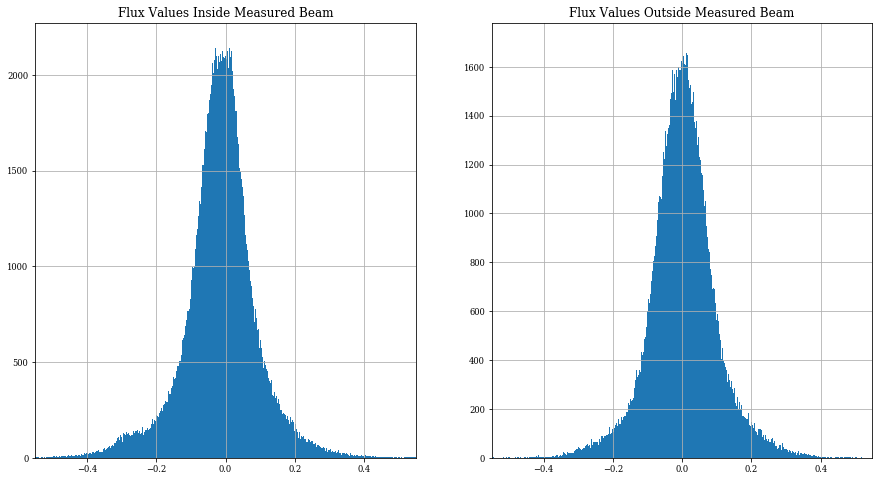

In [9]:
std_out = noise.std()
std_in = noise_in_track.std()

print 'Standard Deviation in the beam measurement:', std_in
print 'Mean in the beam measurement:', noise_in_track.mean()
print 'Max in the beam measurement:', noise_in_track.max()
print 'Min in the beam measurement:', noise_in_track.min()


print '\nStandard Deviation outside the beam measurement:', std_out
print 'Mean outside the beam measurement:', noise.mean()
print 'Max outside the beam measurement:', noise.max()
print 'Min outside the beam measurement:', noise.min()

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.title('Flux Values Inside Measured Beam')
plt.hist(noise_in_track.flatten(), bins = 1000)
plt.xlim([-5*std_in,5*std_in])
plt.grid()

plt.subplot(1,2,2)
plt.title('Flux Values Outside Measured Beam')
plt.hist(noise.flatten(), bins = 1000)
plt.xlim([-5*std_in,5*std_in])
plt.grid()

plt.show()

In [10]:
plt.figure(figsize=(15,8))
plt.title('Flux Distribution of Area Inside vs. Outside of the Beam Measurement')
plt.hist(noise.flatten(), bins = np.linspace(-4,4,500), label='Outside the Beam Measurement',alpha=0.6)
plt.hist(noise_in_track.flatten(), bins = np.linspace(-4,4,500), label='Inside the Beam Measurement',alpha=0.6)
plt.xlim([-0.75,0.75])
plt.legend()
plt.grid()
#plt.show()
plt.savefig('gaussian_noise.png',dpi=300)

In [11]:
np.save('noise_arr',noise)
np.save('noise_in_track_arr',noise_in_track)

## 6. Uniform vs. Natural

When imaging the data the first 

In [20]:
freq_range = '180-190MHz'
freq_ends = [180,190]

files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/180-190MHz_uniform/imgs/*fits'))
plot_data = track_sources(files,tb)

theta_uniform, obs_beam_uniform, obs_std_uniform = observed_beam(plot_data)

freqs = np.arange(freq_ends[0],freq_ends[1])
model_beam = []

for freq in freqs:
    ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=15, n=100)
    model_beam.append(beam)

model_beam = np.mean(model_beam, axis = 0)
model_beam /= model_beam.max()
model_beam = 10*np.log10(model_beam)

In [21]:
freq_range = '180-190MHz'
freq_ends = [180,190]

files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/180-190MHz_natural/imgs/*fits'))
plot_data = track_sources(files,tb)

theta_natural, obs_beam_natural, obs_std_natural = observed_beam(plot_data)

freqs = np.arange(freq_ends[0],freq_ends[1])
model_beam = []

for freq in freqs:
    ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=15, n=100)
    model_beam.append(beam)

model_beam = np.mean(model_beam, axis = 0)
model_beam /= model_beam.max()
model_beam = 10*np.log10(model_beam)

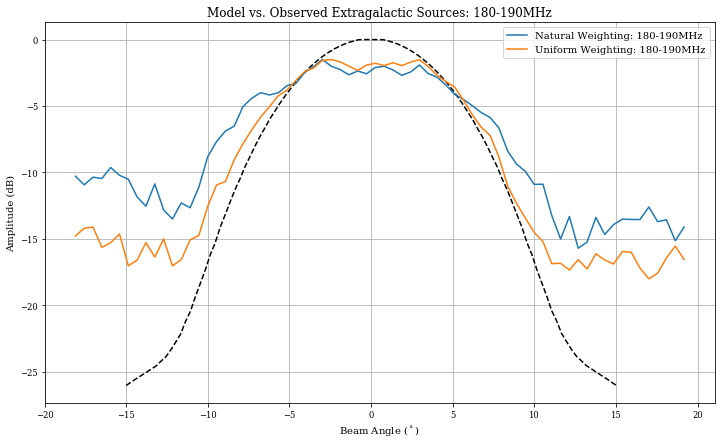

In [22]:
plt.figure(figsize=(12,7))

plt.plot(ang-90,model_beam,'k--')
plt.plot(theta_natural[5:-3],obs_beam_natural[4:-4]-1.5, 
         label='Natural Weighting: ' + freq_range)
plt.plot(theta_uniform[5:-3],obs_beam_uniform[4:-4]-1.5, 
         label='Uniform Weighting: ' + freq_range)
plt.legend()
plt.title('Model vs. Observed Extragalactic Sources: ' + freq_range)
plt.xlabel(r'Beam Angle ($^\circ$)')
plt.ylabel('Amplitude (dB)')
plt.grid()
plt.show()

In [23]:
freq_range = '170-190MHz'
freq_ends = [170,190]

files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/170-190MHz_uniform/imgs/*fits'))
plot_data = track_sources(files,tb)

theta_uniform, obs_beam_uniform, obs_std_uniform = observed_beam(plot_data)

freqs = np.arange(freq_ends[0],freq_ends[1])
model_beam = []

for freq in freqs:
    ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=15, n=100)
    model_beam.append(beam)

model_beam = np.mean(model_beam, axis = 0)
model_beam /= model_beam.max()
model_beam = 10*np.log10(model_beam)

In [24]:
freq_range = '170-190MHz'
freq_ends = [170,190]

files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/170-190MHz_natural/imgs/*fits'))
plot_data = track_sources(files,tb)

theta_natural, obs_beam_natural, obs_std_natural = observed_beam(plot_data)

freqs = np.arange(freq_ends[0],freq_ends[1])
model_beam = []

for freq in freqs:
    ang, beam = hera_beam_freq_slice(hera_beam, freq, ang_from_center=15, n=100)
    model_beam.append(beam)

model_beam = np.mean(model_beam, axis = 0)
model_beam /= model_beam.max()
model_beam = 10*np.log10(model_beam)

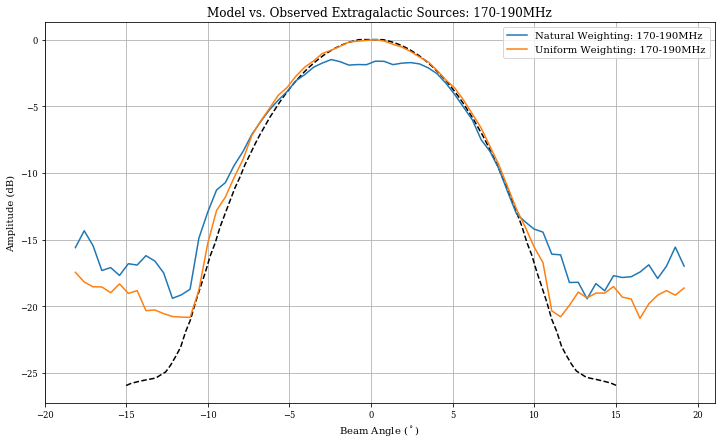

In [25]:
plt.figure(figsize=(12,7))

plt.plot(ang-90,model_beam,'k--')
plt.plot(theta_natural[5:-3],obs_beam_natural[4:-4]-1.5, 
         label='Natural Weighting: ' + freq_range)
plt.plot(theta_uniform[5:-3],obs_beam_uniform[4:-4], 
         label='Uniform Weighting: ' + freq_range)
plt.legend()
plt.title('Model vs. Observed Extragalactic Sources: ' + freq_range)
plt.xlabel(r'Beam Angle ($^\circ$)')
plt.ylabel('Amplitude (dB)')
plt.grid()
plt.show()
#plt.savefig('natural_vs_uniform_180-190MHz.png')

## 7. Creating a 3D Beam Map

In [12]:
tb = add_fluxes(RA_range=('00:00:00','13:00:00'),dec_range=15, min_flux=10)
tb = tb.sort_values(by=['Total flux in region'],ascending=False)
tb.head(5)

,Name of Center,RA,Dec,Total flux in region
42,TGSSADR J052257.7-362735,80.740761,-36.459751,64304.300751
36,TGSSADR J044437.6-280950,71.156670,-28.163950,54120.298416
66,TGSSADR J090147.5-255520,135.448151,-25.922380,49961.298431
49,TGSSADR J063633.0-204233,99.137527,-20.709419,42710.600420
50,TGSSADR J063631.1-203208,99.129791,-20.535730,42533.600426


In [17]:
freq_range = '170-190MHz'
files = np.sort(glob('/data6/HERA/HERA_imaging/IDR2/170-190MHz/imgs/*fits'))
plot_data = track_sources(files,tb)

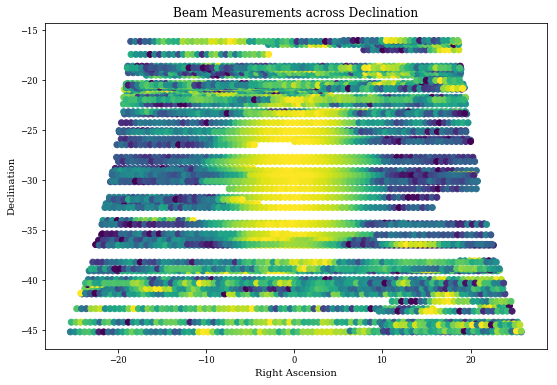

In [18]:
source_info = {item['Name of Center']: {'Dec': item['Dec']} for _, item in tb.iterrows()}

plt.figure(figsize=(9,6))

create_arr = True

for key, item in plot_data.iteritems():
    flux = np.array(item['Flux'])
    ra = np.array(item['RA_diff'])
    dec = np.ones_like(ra)*source_info[key]['Dec']
    plt.scatter(ra,dec,c=10*np.log10(flux))
    if create_arr:
        ras = ra
        decs = dec
        fluxes = flux
        create_arr = False
    else:
        ras = np.hstack([ras,ra])
        decs = np.hstack([decs,dec])
        fluxes = np.hstack([fluxes,flux])
              
plt.title('Beam Measurements across Declination')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()

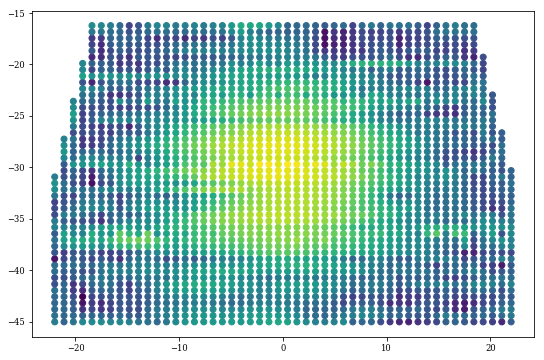

In [15]:
from scipy.interpolate import griddata

xi = np.linspace(-22,22,50)
yi = np.linspace(-45,-15,50)
x,y = np.meshgrid(xi,yi)
zi = griddata((ras,decs),fluxes,(x,y))

plt.figure(figsize=(9,6))
plt.scatter(x,y,c=10*np.log10(zi))
plt.show()

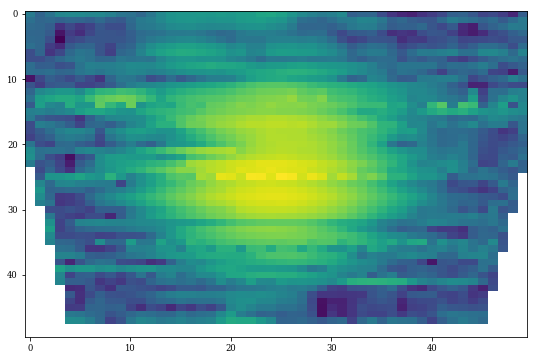

In [16]:
plt.figure(figsize=(9,6))
plt.imshow(10*np.log10(zi),aspect='auto')
plt.show()